In [1]:
# Basic data handling
import pandas as pd
import numpy as np

# Torch + HuggingFace
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AlbertTokenizer

# Visualization (optional but helpful)
import matplotlib.pyplot as plt
import seaborn as sns


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
# Load PHQ-9 dataset
df = pd.read_csv("../data/Updated_PHQ9_Student_Dataset.csv")

# Show first few rows
df.head()

,Age,Gender,Little interest or pleasure in doing things?,"Feeling down, depressed, or hopeless?","Trouble falling or staying asleep, or sleeping too much?",Feeling tired or having little energy?,Poor appetite or overeating?,Feeling bad about yourself — or that you are a failure or have let yourself or your family down?,"Trouble concentrating on things, such as reading the newspaper or watching television?",Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual?,"Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?",PHQ-9 Total Score,Depression Level
0,22,Male,Not at all,Several days,Not at all,Several days,Not at all,More than half the days,More than half the days,Several days,Not at all,7,Mild
1,25,Male,Several days,Nearly every day,More than half the days,Several days,Several days,More than half the days,Nearly every day,Nearly every day,Nearly every day,19,Moderately Severe
2,25,Male,Nearly every day,Several days,Nearly every day,Nearly every day,More than half the days,Nearly every day,More than half the days,Nearly every day,Not at all,20,Severe
3,26,Male,Nearly every day,Not at all,Nearly every day,Nearly every day,More than half the days,Nearly every day,Not at all,Not at all,Nearly every day,17,Moderately Severe
4,19,Male,More than half the days,Several days,More than half the days,More than half the days,Nearly every day,Several days,Nearly every day,Nearly every day,Nearly every day,20,Severe


In [23]:
# Check column names and dataset size
print("Columns:", df.columns)
print("Shape:", df.shape)

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Columns: Index(['Age', 'Gender', 'Little interest or pleasure in doing things?',
       'Feeling down, depressed, or hopeless?',
       'Trouble falling or staying asleep, or sleeping too much?',
       'Feeling tired or having little energy?',
       'Poor appetite or overeating?',
       'Feeling bad about yourself — or that you are a failure or have let yourself or your family down?',
       'Trouble concentrating on things, such as reading the newspaper or watching television?',
       'Moving or speaking so slowly that other people could have noticed? Or the opposite — being so fidgety or restless that you have been moving around a lot more than usual?',
       'Thoughts that you would be better off dead, or thoughts of hurting yourself in some way?',
       'PHQ-9 Total Score', 'Depression Level'],
      dtype='object')
Shape: (400, 13)

Missing values:
Age                                                                                                                             

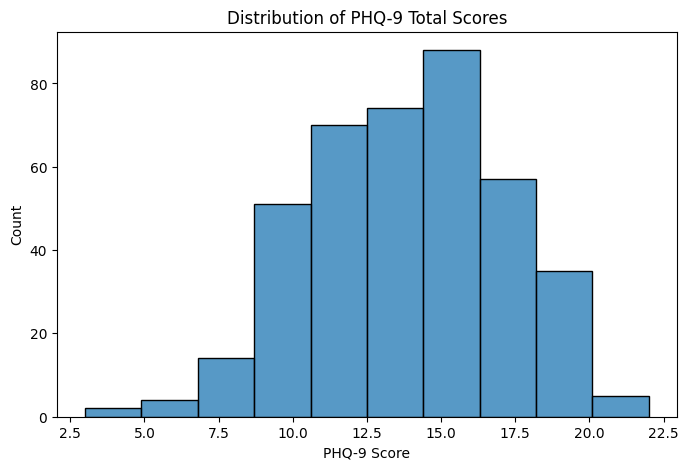

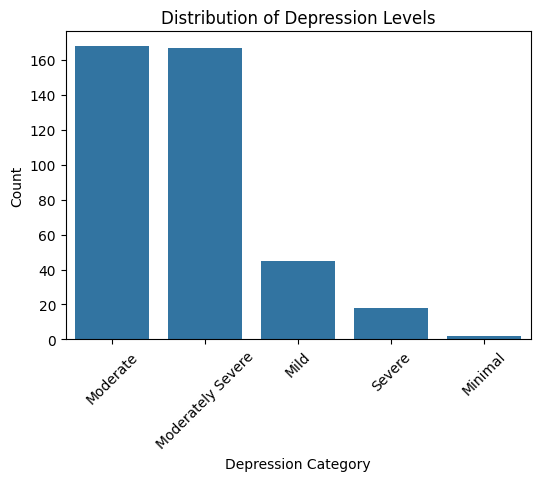

In [24]:
# Visualize PHQ-9 total score distribution
plt.figure(figsize=(8,5))
sns.histplot(df["PHQ-9 Total Score"], bins=10, kde=False)
plt.title("Distribution of PHQ-9 Total Scores")
plt.xlabel("PHQ-9 Score")
plt.ylabel("Count")
plt.show()

# Visualize Depression Level distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Depression Level", order=df["Depression Level"].value_counts().index)
plt.title("Distribution of Depression Levels")
plt.xlabel("Depression Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [25]:
from sklearn.preprocessing import LabelEncoder

# Encode Depression Level into numeric labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Depression Level"])

# Check mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Preview updated dataframe
df[["PHQ-9 Total Score", "Depression Level", "label"]].head()


Label Mapping: {'Mild': np.int64(0), 'Minimal': np.int64(1), 'Moderate': np.int64(2), 'Moderately Severe': np.int64(3), 'Severe': np.int64(4)}


,PHQ-9 Total Score,Depression Level,label
0,7,Mild,0
1,19,Moderately Severe,3
2,20,Severe,4
3,17,Moderately Severe,3
4,20,Severe,4


In [26]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["PHQ-9 Total Score"].astype(str).values,   # input as text (for tokenizer)
    df["label"].values,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

print("Train size:", len(train_texts))
print("Validation size:", len(val_texts))


Train size: 320
Validation size: 80


In [27]:
!pip install sentencepiece


In [28]:
import sentencepiece
print("SentencePiece version:", sentencepiece.__version__)


SentencePiece version: 0.2.1


In [29]:
from transformers import AlbertTokenizer

# Load ALBERT tokenizer
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

# Tokenize train and validation data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=64)

print("Example tokens:", train_encodings["input_ids"][0][:10])


Example tokens: [2, 547, 3]


In [30]:
class PHQ9Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Build datasets
train_dataset = PHQ9Dataset(train_encodings, train_labels)
val_dataset = PHQ9Dataset(val_encodings, val_labels)

print("Dataset sizes -> Train:", len(train_dataset), " Val:", len(val_dataset))


Dataset sizes -> Train: 320  Val: 80


In [31]:
sample = train_dataset[0]
print(sample)

{'input_ids': tensor([  2, 547,   3]), 'token_type_ids': tensor([0, 0, 0]), 'attention_mask': tensor([1, 1, 1]), 'labels': tensor(2)}


In [32]:
from transformers import AlbertForSequenceClassification

# Number of unique depression levels (labels)
num_labels = len(df["label"].unique())

# Load ALBERT model with classification head
model = AlbertForSequenceClassification.from_pretrained(
    "albert-base-v2",
    num_labels=num_labels
)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
!pip install tf-keras


In [34]:
pip install --upgrade transformers


Note: you may need to restart the kernel to use updated packages.


In [35]:
# -------------------------
# Manual training loop (PyTorch + Transformers)
# -------------------------
import os
import time
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW   # ✅ use PyTorch version
from transformers import AlbertForSequenceClassification, AlbertTokenizerFast, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score


# Settings / hyperparams
model_name = "albert-base-v2"
num_labels = len(df["label"].unique())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 5
train_batch_size = 8   # reduce to 4 if you hit OOM
eval_batch_size = 8
learning_rate = 2e-5
save_dir = "../models/phq9_albert_manual"

# Load model + tokenizer
tokenizer = AlbertTokenizerFast.from_pretrained(model_name)
model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)

# DataLoaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=eval_batch_size)

# Optimizer + scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * epochs
warmup_steps = int(0.06 * total_steps) if total_steps > 0 else 0
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Loss (the model returns loss if labels provided, but we'll compute ourselves for clarity)
loss_fn = nn.CrossEntropyLoss()

best_val_loss = float("inf")
os.makedirs(save_dir, exist_ok=True)

for epoch in range(1, epochs + 1):
    # ---------- TRAIN ----------
    model.train()
    train_losses = []
    t0 = time.time()
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss  # model returns loss when labels are passed
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    t_train = time.time() - t0

    # ---------- EVAL ----------
    model.eval()
    val_losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_losses.append(loss.item())
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    avg_val_loss = np.mean(val_losses) if len(val_losses) else 0.0
    val_acc = accuracy_score(all_labels, all_preds) if len(all_labels) else 0.0

    print(f"Epoch {epoch}/{epochs} — train_loss: {avg_train_loss:.4f}, val_loss: {avg_val_loss:.4f}, val_acc: {val_acc:.4f}, time: {t_train:.1f}s")

    # Save best model (by val loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained(save_dir)
        tokenizer.save_pretrained(save_dir)
        print("Saved best model to", save_dir)


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 — train_loss: 1.2068, val_loss: 0.6128, val_acc: 0.9375, time: 24.1s
Saved best model to ../models/phq9_albert_manual
Epoch 2/5 — train_loss: 0.3093, val_loss: 0.1655, val_acc: 0.9500, time: 18.4s
Saved best model to ../models/phq9_albert_manual
Epoch 3/5 — train_loss: 0.1942, val_loss: 0.0943, val_acc: 0.9500, time: 15.5s
Saved best model to ../models/phq9_albert_manual
Epoch 4/5 — train_loss: 0.0853, val_loss: 0.0546, val_acc: 1.0000, time: 15.5s
Saved best model to ../models/phq9_albert_manual
Epoch 5/5 — train_loss: 0.0562, val_loss: 0.0443, val_acc: 1.0000, time: 15.3s
Saved best model to ../models/phq9_albert_manual


In [36]:
import os
p = "../models/phq9_albert_manual"
print("Files in", p)
for f in sorted(os.listdir(p)):
    print(" -", f)

Files in ../models/phq9_albert_manual
 - config.json
 - model.safetensors
 - special_tokens_map.json
 - spiece.model
 - tokenizer.json
 - tokenizer_config.json


In [37]:
from transformers import AlbertTokenizerFast, AlbertForSequenceClassification

MODEL_DIR = "../models/phq9_albert_manual"

tokenizer = AlbertTokenizerFast.from_pretrained(MODEL_DIR, local_files_only=True)
model = AlbertForSequenceClassification.from_pretrained(MODEL_DIR, local_files_only=True)

print("Tokenizer and model loaded successfully!")


Tokenizer and model loaded successfully!


In [38]:
# 1) list models/ directory to confirm actual folder name
import os
base = "../models"
print("models/ contains:")
for f in sorted(os.listdir(base)):
    print(" -", f)

# 2) list files in the specific model dir(s) we expect
candidates = [os.path.join(base, d) for d in os.listdir(base) if d.lower().startswith("phq")]
for d in candidates:
    print("\nFiles in", d)
    for fn in sorted(os.listdir(d)):
        print("  -", fn)

# 3) quick existence check for tokenizer files (spiece.model or spiece.model typo)
for d in candidates:
    print("\nChecking required tokenizer files in", d)
    print(" has tokenizer.json?", os.path.exists(os.path.join(d, "tokenizer.json")))
    print(" has tokenizer_config.json?", os.path.exists(os.path.join(d, "tokenizer_config.json")))
    print(" has spiece.model?", os.path.exists(os.path.join(d, "spiece.model")))
    print(" has spiece.model?", os.path.exists(os.path.join(d, "spiece.model")))


models/ contains:
 - phq9_albert_manual

Files in ../models\phq9_albert_manual
  - config.json
  - model.safetensors
  - special_tokens_map.json
  - spiece.model
  - tokenizer.json
  - tokenizer_config.json

Checking required tokenizer files in ../models\phq9_albert_manual
 has tokenizer.json? True
 has tokenizer_config.json? True
 has spiece.model? True
 has spiece.model? True


In [ ]:
# -------------------------
# RUN MODEL ON CUSTOM TEXTS
# -------------------------
import os, json
import torch
import numpy as np
from transformers import AlbertForSequenceClassification, AlbertTokenizerFast

# CONFIG: change if needed
MODEL_DIR = "../models/phq9_albert_manual"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TOP_K = 3         # show top-k labels per example
MAX_LEN = 128

# 1) Load model + tokenizer (local files only)
tokenizer = AlbertTokenizerFast.from_pretrained(MODEL_DIR, local_files_only=True)
model = AlbertForSequenceClassification.from_pretrained(MODEL_DIR, local_files_only=True)
model.to(DEVICE)
model.eval()

# 2) Try to load label_map (optional)
label_map_path = os.path.join(os.path.dirname(MODEL_DIR), "label_map.pkl")
label_map = None
if os.path.exists(label_map_path):
    import pickle
    try:
        label_map = pickle.load(open(label_map_path, "rb"))
        print("Loaded label_map from:", label_map_path)
    except Exception:
        label_map = None

# If label_map is None, build a fallback numeric->name mapping from config if possible
if label_map is None:
    try:
        cfg = model.config.to_dict()
        num_labels = cfg.get("num_labels", None)
        if num_labels:
            label_map = {i: f"label_{i}" for i in range(num_labels)}
        else:
            label_map = None
    except Exception:
        label_map = None

print("Using device:", DEVICE)
print("Label map (sample):", dict(list(label_map.items())[:5]) if label_map else "None")

# 3) Put your custom texts here (edit as needed)
custom_texts = [
    "I feel hopeless and sleep very poorly these days.",
    "I am fine, enjoying my usual routine and sleeping well.",
    "Sometimes I feel sad but I can still do my tasks."
]

# 4) Tokenize and run predictions (batched)
enc = tokenizer(custom_texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt")
input_ids = enc["input_ids"].to(DEVICE)
attention_mask = enc["attention_mask"].to(DEVICE)

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits   # shape [B, num_labels]
    probs = torch.softmax(logits, dim=-1).cpu().numpy()

# 5) Present results
for i, text in enumerate(custom_texts):
    p = probs[i]
    pred_idx = int(np.argmax(p))
    pred_prob = float(p[pred_idx])
    # Top-k classes
    topk_idx = list(np.argsort(p)[-TOP_K:][::-1])
    topk = [(idx, float(p[idx]), label_map.get(idx, str(idx)) if label_map else idx) for idx in topk_idx]

    print("\n---")
    print("Text:", text)
    print("Predicted index:", pred_idx)
    print("Predicted label:", label_map.get(pred_idx, pred_idx) if label_map else pred_idx)
    print("Top prob:", f"{pred_prob:.4f}")
    print("Top-{}:".format(TOP_K))
    for idx, pr, name in topk:
        print(f"  idx={idx}  prob={pr:.4f}  name={name}")
    print("Full probs:", np.round(p, 4).tolist())

# Optional: return results as a list/dict if you want to use programmatically
results = []
for i, text in enumerate(custom_texts):
    p = probs[i]
    pred_idx = int(np.argmax(p))
    results.append({
        "text": text,
        "pred_idx": pred_idx,
        "pred_label": label_map.get(pred_idx, pred_idx) if label_map else pred_idx,
        "pred_prob": float(p[pred_idx]),
        "probs": p.tolist()
    })

# show results dataframe if pandas is available
try:
    import pandas as pd
    display(pd.DataFrame(results))
except Exception:
    pass


Using device: cpu
Label map (sample): None

---
Text: I feel hopeless and sleep very poorly these days.
Predicted index: 2
Predicted label: 2
Top prob: 0.8538
Top-3:
  idx=2  prob=0.8538  name=2
  idx=0  prob=0.1004  name=0
  idx=4  prob=0.0206  name=4
Full probs: [0.10040000081062317, 0.018699999898672104, 0.8537999987602234, 0.006399999838322401, 0.020600000396370888]

---
Text: I am fine, enjoying my usual routine and sleeping well.
Predicted index: 2
Predicted label: 2
Top prob: 0.7672
Top-3:
  idx=2  prob=0.7672  name=2
  idx=0  prob=0.1705  name=0
  idx=1  prob=0.0314  name=1
Full probs: [0.1704999953508377, 0.03139999881386757, 0.7671999931335449, 0.008200000040233135, 0.022700000554323196]

---
Text: I feel hopeless and suicidal
Predicted index: 2
Predicted label: 2
Top prob: 0.8164
Top-3:
  idx=2  prob=0.8164  name=2
  idx=0  prob=0.1398  name=0
  idx=1  prob=0.0211  name=1
Full probs: [0.13979999721050262, 0.0210999995470047, 0.8163999915122986, 0.0066999997943639755, 0.01610

,text,pred_idx,pred_label,pred_prob,probs
0,I feel hopeless and sleep very poorly these days.,2,2,0.853768,"[0.10042795538902283, 0.018747074529528618, 0...."
1,"I am fine, enjoying my usual routine and sleep...",2,2,0.767205,"[0.1704617291688919, 0.03140789270401001, 0.76..."
2,I feel hopeless and suicidal,2,2,0.816377,"[0.13975612819194794, 0.021055132150650024, 0...."
